In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
path="/content/drive/MyDrive/un_master"

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import keras_tuner as kt
import matplotlib.pyplot as plt
import os
import json
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [4]:
import os
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
# =============================================================================
# 1. Cargar Datos desde Archivo
# =============================================================================
synthetic_df = pd.read_csv(os.path.join(path, "synthetic_data.txt"), sep="\t")
X = synthetic_df.drop("Mfalla", axis=1).values
y = synthetic_df["Mfalla"].values

# Codificar etiquetas
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

In [5]:
# =============================================================================
# 2. Definir arquitectura de la MLP con hiperparámetros
# =============================================================================
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X.shape[1],)))
    num_layers = hp.Int("num_layers", 1, 3)

    for i in range(num_layers):
        units=hp.Int(f"units_{i+1}", 16, 128, step=16)
        activation=hp.Choice(f"activation_{i+1}", ["relu", "tanh"])
        dropout=round(hp.Float(f"dropout_{i+1}", 0.1, 0.5, step=0.1), 2)
        model.add(Dense(units=units, activation=activation))
        model.add(Dropout(rate=dropout))
    num_classes = y_encoded.shape[1] if len(y_encoded.shape) > 1 else len(np.unique(y))  # Manejo One-Hot
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice("learning_rate", [0.01, 0.001, 0.0001])),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model


In [6]:
from tensorflow.keras import backend as K
K.clear_session()
os.makedirs(path, exist_ok=True)
# =============================================================================
# 3. Validación Cruzada con K-Fold y KerasTuner
# =============================================================================
batch_sizes = [16, 32, 64, 128]  # 🔹 Lista de batch_sizes a evaluar
results = []  # 🔹 Para almacenar las métricas de cada batch_size
hps_per_batch = {} # Diccionario para guardar hiperparámetros por batch size
histories_dict = {}  # Diccionario para guardar los históricos de cada batch_size

for batch_size in batch_sizes:
    print(f"\n🔹 Entrenando con batch_size = {batch_size}")
    fold_accuracies = []
    fold_losses = []
    all_histories = []
    histories_dict[batch_size] = all_histories
    hps_per_fold = []
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(X, y)):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

        tuner = kt.RandomSearch(
            build_model,
            objective="val_accuracy",
            max_trials=20,
            executions_per_trial=3,
            directory=os.path.join(path, f"rskv_results_bs{batch_size}"),
            project_name=f"mlp_rskv{fold}_bs{batch_size}"
            )

        tuner.search(X_train, y_train, epochs=100, validation_data=(X_val, y_val), verbose=0)

        best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
        best_hps_values = best_hps.values

        early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)

        best_model = tuner.hypermodel.build(best_hps)
        history = best_model.fit(X_train, y_train, epochs=100, batch_size=batch_size,
                             validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

        all_histories.append(history)

        ruta = os.path.join(path, "rskv_train")
        os.makedirs(ruta, exist_ok=True)
        best_model.save(os.path.join(ruta,(f"mlp_bm_kv{fold}_bs{batch_size}.keras")))

        fold_accuracies.append(history.history["val_accuracy"][-1])
        fold_losses.append(history.history["val_loss"][-1])

        histories_series = {batch_size : [hist.history for hist in histories] for batch_size, histories in histories_dict.items()}
        with open(os.path.join(ruta, f"mlp_bhpf_pbs_hy.json"), "w") as f:
            json.dump(histories_series, f, indent=4)
        num_layers = best_hps_values["num_layers"]
        filtered_hps = {
            k: v for k, v in best_hps_values.items()
            if not any(k.startswith(prefix) and "_" in k and int(k.split("_")[1]) > num_layers
                       for prefix in ["units", "activation", "dropout"])
            or k == "num_layers" or k == "learning_rate"
        }

        hps_per_fold.append(filtered_hps)
        hps_per_batch[batch_size] = hps_per_fold
        with open(os.path.join(ruta, f"mlp_bhpf_pbs.json"), "w") as f:
            json.dump(hps_per_batch, f, indent=4)

    # 🔹 Guardar resultados de este batch_size
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    mean_loss = np.mean(fold_losses)
    std_loss = np.std(fold_losses)

    results.append({
        "batch_size": batch_size,
        "mean_accuracy": mean_acc,
        "std_accuracy": std_acc,
        "mean_loss": mean_loss,
        "std_loss": std_loss
    })

    print(f"🔹 batch_size = {batch_size} → Exactitud: {mean_acc:.5f} ± {std_acc:.5f}, Pérdida: {mean_loss:.5f} ± {std_loss:.5f}")

# 🔹 Guardar resultados en JSON para análisis posterior
with open(os.path.join(ruta, "mlp_batch_size_results.json"), "w") as f:
    json.dump(results, f, indent=4)


🔹 Entrenando con batch_size = 16
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs16/mlp_rskv0_bs16/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs16/mlp_rskv1_bs16/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs16/mlp_rskv2_bs16/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs16/mlp_rskv3_bs16/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs16/mlp_rskv4_bs16/tuner0.json
🔹 batch_size = 16 → Exactitud: 0.90989 ± 0.00842, Pérdida: 0.29052 ± 0.06905

🔹 Entrenando con batch_size = 32
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs32/mlp_rskv0_bs32/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs32/mlp_rskv1_bs32/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_results_bs32/mlp_rskv2_bs32/tuner0.json
Reloading Tuner from /content/drive/MyDrive/un_master/rskv_resu

In [18]:
# =============================================================================
# 4. Entrenar Modelo Final con los Mejores Hiperparámetros
# =============================================================================
# 🔹 Fijar la semilla para reproducibilidad
semilla = 42
random.seed(semilla)
np.random.seed(semilla)
tf.random.set_seed(semilla)

epsilon = 1e-8

for batch_size in batch_sizes:
    print(f"\n🔹 Batch_size = {batch_size}")
    fold_accuracies = [hist.history["val_accuracy"][-1] for hist in histories_dict[batch_size]]
    fold_losses = [hist.history["val_loss"][-1] for hist in histories_dict[batch_size]]
    fold_std_acc = [np.std(hist.history["val_accuracy"]) for hist in histories_dict[batch_size]]
    fold_std_loss = [np.std(hist.history["val_loss"]) for hist in histories_dict[batch_size]]

    for fold, (acc, loss, std_acc, std_loss) in enumerate(zip(fold_accuracies, fold_losses, fold_std_acc, fold_std_loss)):
        score = acc / (loss + std_acc + std_loss + epsilon)
        print(f" Fold {fold}: SPS = {score:.5f}, Exactitud_val = {acc:.5f} ± {std_acc:.5f}, Pérdida_val = {loss:.5f} ± {std_loss:.5f}")

# Seleccionar el mejor batch basado en el criterio SPS (Puntaje estabilidad - exactitud)
best_batch = max(results, key=lambda x: x["mean_accuracy"] / (x["mean_loss"] + x["std_accuracy"] + x["std_loss"] + epsilon))["batch_size"]
# Imprimir el mejor batch y su puntaje SPS
best_result = next(r for r in results if r["batch_size"] == best_batch)
best_score = best_result["mean_accuracy"] / (best_result["mean_loss"] + best_result["std_accuracy"] + best_result["std_loss"] + epsilon)
print(f"\n El mejor batch_size encontrado es: {best_batch} con un SPS de {best_score:.5f}")
# Imprimir los valores de cada batch_size
print("\n Comparación de Batch Sizes:")
for r in results:
    score = r["mean_accuracy"] / (r["mean_loss"] + r["std_accuracy"] + r["std_loss"] + epsilon)
    print(f"Batch_size = {r['batch_size']}: SPS = {score:.5f}, " f"Exactitud = {r['mean_accuracy']:.5f} ± {r['std_accuracy']:.5f}, " f"Pérdida = {r['mean_loss']:.5f} ± {r['std_loss']:.5f}")

fold_accuracies = [hist.history["val_accuracy"][-1] for hist in histories_dict[best_batch]]
fold_losses = [hist.history["val_loss"][-1] for hist in histories_dict[best_batch]]
fold_std_acc = [np.std(hist.history["val_accuracy"]) for hist in histories_dict[best_batch]]
fold_std_loss = [np.std(hist.history["val_loss"]) for hist in histories_dict[best_batch]]

# 🔹 Mostrar los valores de cada fold dentro del batch óptimo antes de seleccionar el mejor
print(f"\n Resultados de los folds dentro del batch: {best_batch} óptimo:")
for fold, (acc, loss, std_acc, std_loss) in enumerate(zip(fold_accuracies, fold_losses, fold_std_acc, fold_std_loss)):
    score = acc / (loss + std_acc + std_loss + epsilon)
    print(f" Fold {fold}: SPS = {score:.5f}, Exactitud_val = {acc:.5f} ± {std_acc:.5f}, Pérdida_val = {loss:.5f} ± {std_loss:.5f}")

best_fold_index = max(range(len(fold_accuracies)), key=lambda i: fold_accuracies[i] / (fold_losses[i] + fold_std_acc[i] + fold_std_loss[i] + epsilon))
best_fold_acc = fold_accuracies[best_fold_index]
best_fold_loss = fold_losses[best_fold_index]
best_fold_stda = fold_std_acc[best_fold_index]
best_fold_stdl = fold_std_loss[best_fold_index]

print(f"\n El mejor fold dentro del batch {best_batch} es: {best_fold_index}")

# 🔹 Obtener los hiperparámetros asociados al mejor fold
best_hps = hps_per_batch[best_batch][best_fold_index]

# 🔹 Guardar los hiperparámetros con su métrica
hps_ac_ls = [(best_hps, best_fold_acc / (best_fold_loss + best_fold_stda + best_fold_stdl + epsilon))]
hps_ac_ls.sort(key=lambda x: x[1], reverse=True)

# 🔹 Imprimir los resultados finales
print("\n Resultados de la mejor combinación de hiperparámetros basado en SPS:")
for hps, score in hps_ac_ls:
    print(f"Hiperparámetro: {hps}, Score: {score:.5f}")

# 🔹 Extraer los mejores hiperparámetros para construir el modelo
best_hyperparams = hps_ac_ls[0][0]
hp = kt.HyperParameters()
for key, value in best_hyperparams.items():
    hp.values[key] = value

# 🔹 Construcción y entrenamiento del modelo final
final_model = build_model(hp)

final_model.compile(optimizer=Adam(learning_rate=best_hyperparams["learning_rate"]),
                    loss="categorical_crossentropy", metrics=["accuracy"])

early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
final_history = final_model.fit(X_train, y_train, epochs=100, batch_size=best_batch,
                                validation_data=(X_val, y_val), verbose=0, callbacks=[early_stop])

# 🔹 Guardar el modelo y los hiperparámetros
final_model.save(os.path.join(ruta, "mlp_bm_gkv.keras"))
with open(os.path.join(ruta, "mlp_bm_hps.json"), "w") as f:
    json.dump(best_hyperparams, f, indent=4)

print("\n✅ Entrenamiento del modelo final completado y guardado correctamente.")


🔹 Batch_size = 16
 Fold 0: SPS = 2.48883, Exactitud_val = 0.91304 ± 0.01508, Pérdida_val = 0.29048 ± 0.06129
 Fold 1: SPS = 1.91801, Exactitud_val = 0.90338 ± 0.03994, Pérdida_val = 0.31221 ± 0.11885
 Fold 2: SPS = 3.38862, Exactitud_val = 0.92233 ± 0.00963, Pérdida_val = 0.16244 ± 0.10011
 Fold 3: SPS = 1.35941, Exactitud_val = 0.89806 ± 0.05027, Pérdida_val = 0.31825 ± 0.29211
 Fold 4: SPS = 2.18657, Exactitud_val = 0.91262 ± 0.00980, Pérdida_val = 0.36924 ± 0.03834

🔹 Batch_size = 32
 Fold 0: SPS = 2.08708, Exactitud_val = 0.91787 ± 0.02607, Pérdida_val = 0.20443 ± 0.20930
 Fold 1: SPS = 1.18567, Exactitud_val = 0.90338 ± 0.10089, Pérdida_val = 0.27523 ± 0.38580
 Fold 2: SPS = 1.00304, Exactitud_val = 0.93204 ± 0.15229, Pérdida_val = 0.16926 ± 0.60767
 Fold 3: SPS = 0.91321, Exactitud_val = 0.90291 ± 0.10736, Pérdida_val = 0.28606 ± 0.59530
 Fold 4: SPS = 2.65737, Exactitud_val = 0.90777 ± 0.01128, Pérdida_val = 0.22077 ± 0.10955

🔹 Batch_size = 64
 Fold 0: SPS = 1.62407, Exactitud

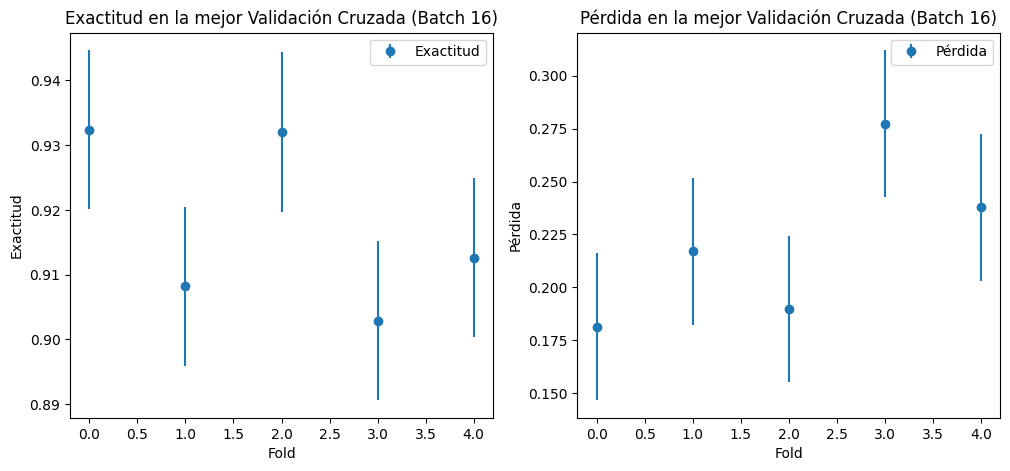

<ipython-input-19-7eeee10caada>:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = plt.boxplot([fold_accuracies], labels=[f"Combinación mejores hiperparámetros del Batch {best_batch}"], patch_artist=True, showmeans=True, whis=1.5)


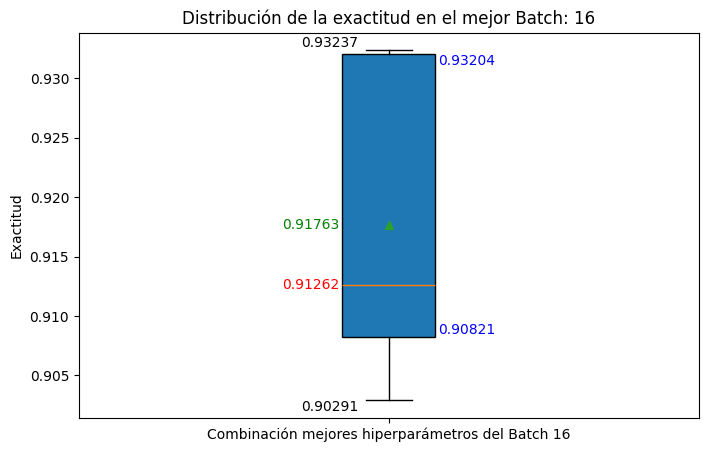

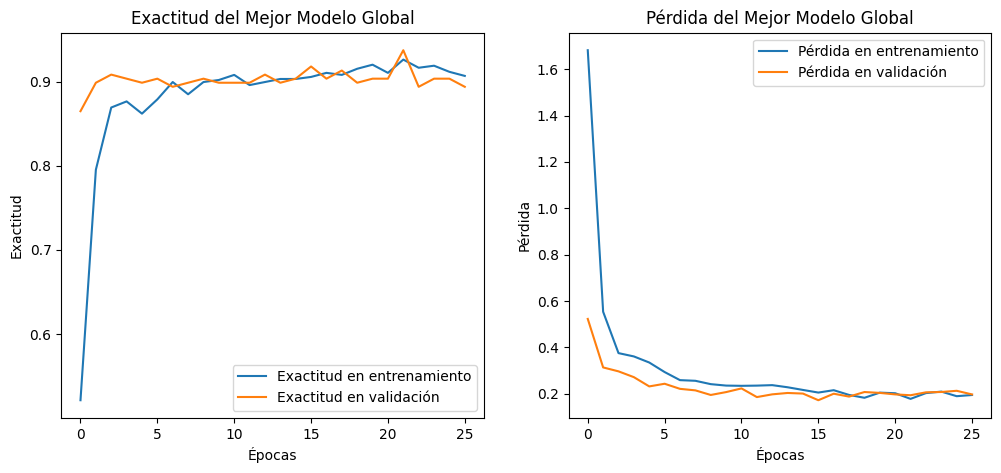

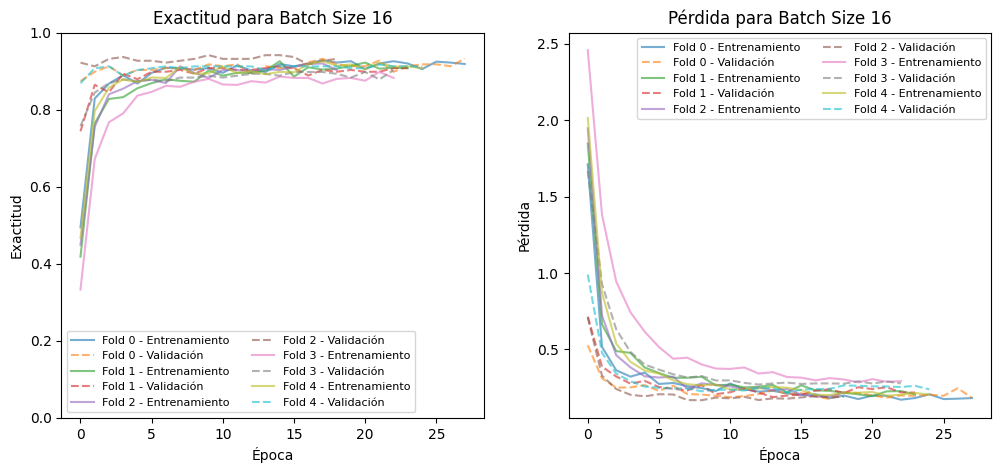

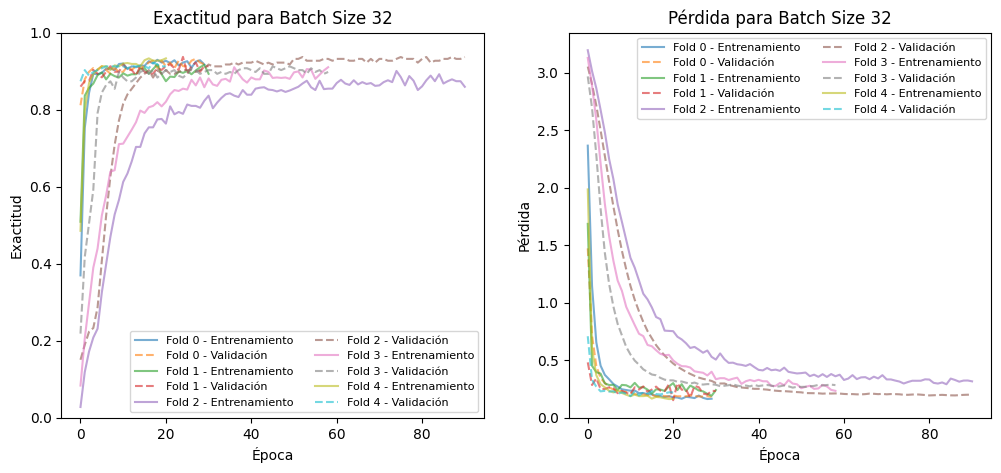

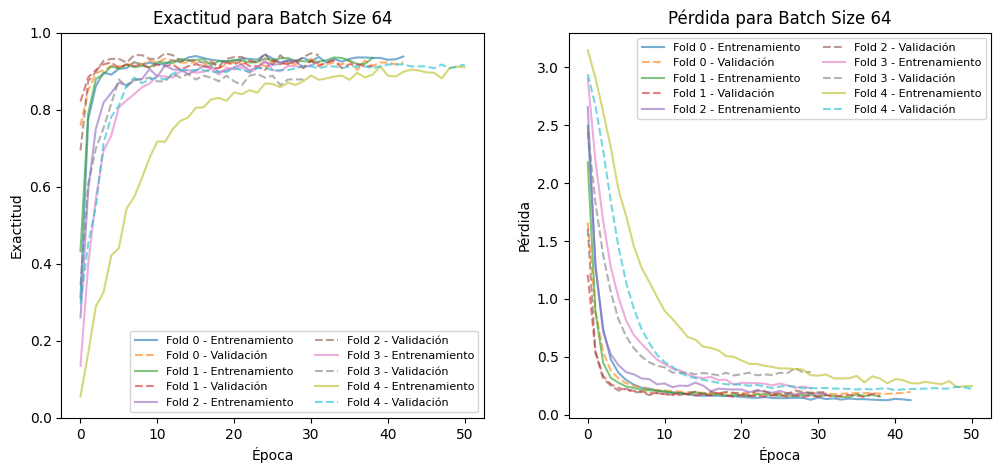

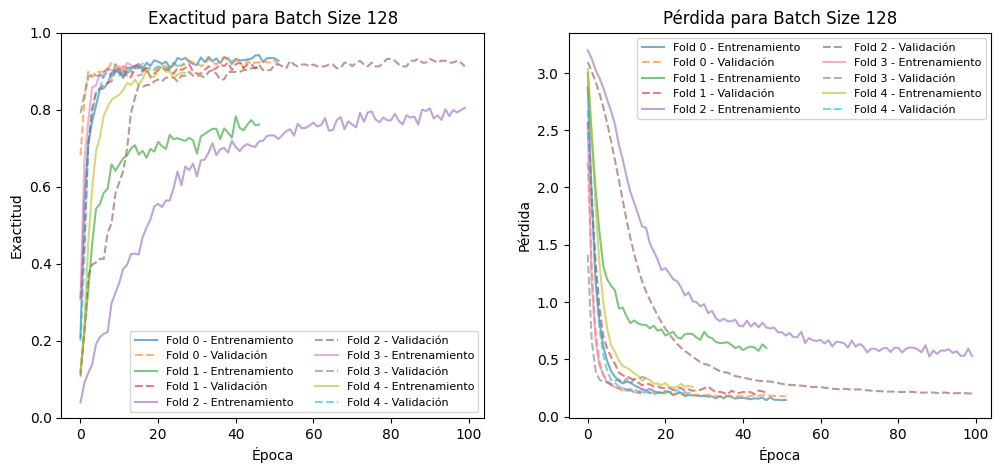

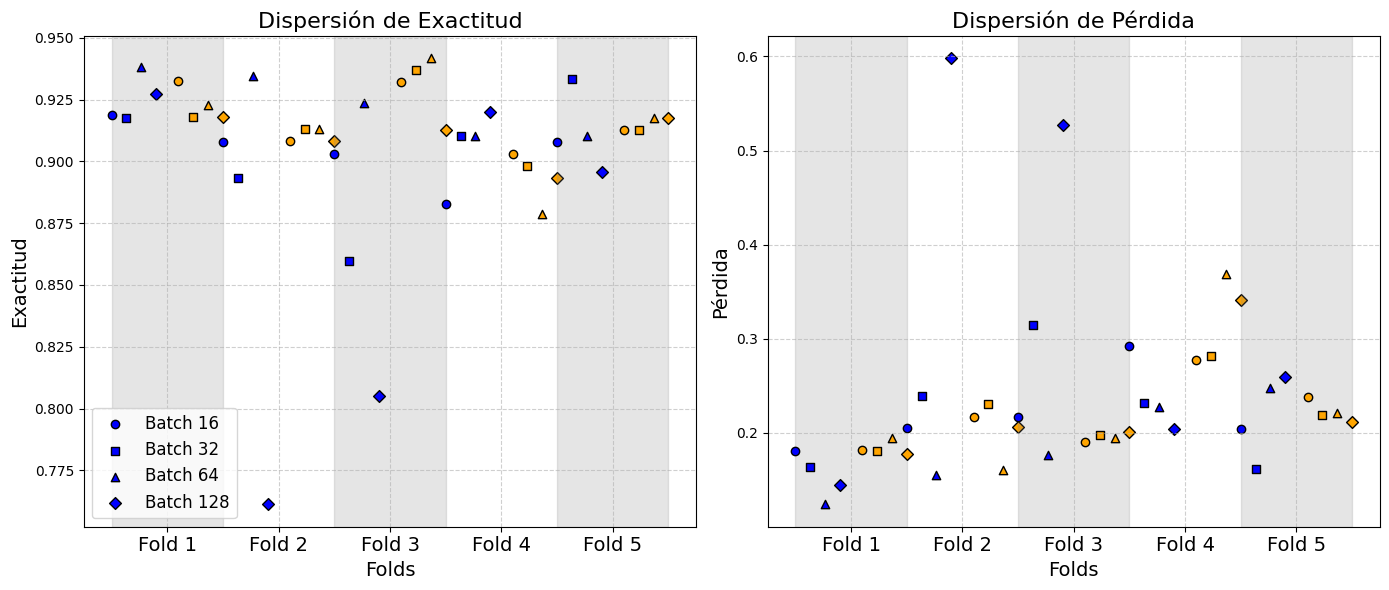

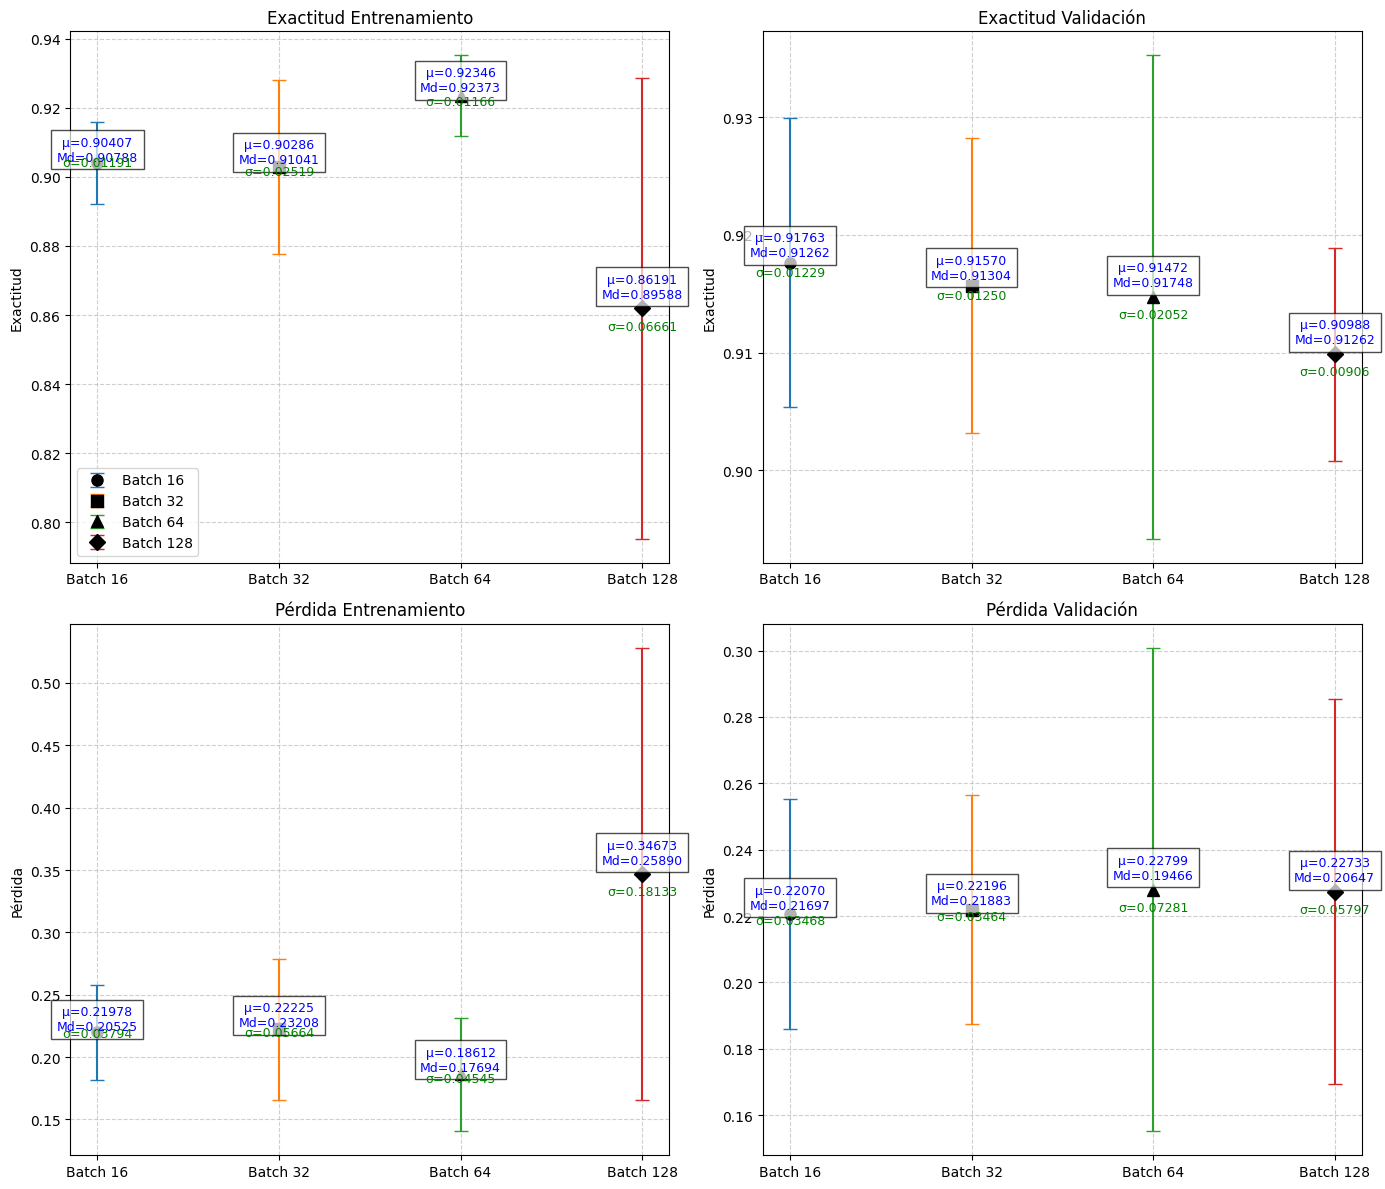

Media de exactitud en validación cruzada: 0.91763 ± 0.01229
Media de pérdida en validación cruzada: 0.22070 ± 0.03468
Media de exactitud en entrenamiento: 0.86191 ± 0.06661
Media de pérdida en entrenamiento: 0.34673 ± 0.18133
Media de exactitud en del mejor fold del mejor batch en validación: 0.93237 ± 0.00000
Media de pérdida en validación: 0.18141 ± 0.00000
Mejores hiperparámetros del batch_size con mejor desempeño: batch_size:16  {'num_layers': 1, 'units_1': 128, 'activation_1': 'relu', 'dropout_1': 0.5, 'learning_rate': 0.01}


In [19]:
# =============================================================================
# 5. Visualización de resultados para los folds del mejor Batch Size
# =============================================================================
train_accuracies = [history.history["accuracy"][-1] for history in all_histories]
train_losses = [history.history["loss"][-1] for history in all_histories]

val_accuracies = fold_accuracies  # Exactitud de validación
val_losses = fold_losses  # Pérdida de validación

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.errorbar(range(5), fold_accuracies, yerr=np.std(fold_accuracies), fmt='o', label='Exactitud')
plt.title(f"Exactitud en la mejor Validación Cruzada (Batch {best_batch})")
plt.xlabel("Fold")
plt.ylabel("Exactitud")
plt.legend()

plt.subplot(1, 2, 2)
plt.errorbar(range(5), fold_losses, yerr=np.std(fold_losses), fmt='o', label='Pérdida')
plt.title(f"Pérdida en la mejor Validación Cruzada (Batch {best_batch})")
plt.xlabel("Fold")
plt.ylabel("Pérdida")
plt.legend()
plt.show()

# 🔹 Visualización de la distribución de exactitud por fold
# Calcular estadísticas de la caja
q1 = np.percentile(fold_accuracies, 25)  # Primer cuartil
q3 = np.percentile(fold_accuracies, 75)  # Tercer cuartil
mediana = np.median(fold_accuracies)  # Mediana
media = np.mean(fold_accuracies)
minimo = np.min(fold_accuracies)  # Valor mínimo
maximo = np.max(fold_accuracies)  # Valor máximo

plt.figure(figsize=(8, 5))

# Crear boxplot con bigotes visibles
box = plt.boxplot([fold_accuracies], labels=[f"Combinación mejores hiperparámetros del Batch {best_batch}"], patch_artist=True, showmeans=True, whis=1.5)

# Mostrar etiquetas numéricas en los valores clave
plt.text(0.92, mediana, f"{mediana:.5f}", verticalalignment='center', horizontalalignment='right', fontsize=10, color='red')
plt.text(0.92, media, f"{media:.5f}", verticalalignment='center', horizontalalignment='right', fontsize=10, color='green')
plt.text(1.08, q1, f"{q1:.5f}", verticalalignment='bottom', horizontalalignment='left', fontsize=10, color='blue')
plt.text(1.08, q3, f"{q3:.5f}", verticalalignment='top', horizontalalignment='left', fontsize=10, color='blue')
plt.text(0.95, minimo, f"{minimo:.5f}", verticalalignment='top', horizontalalignment='right', fontsize=10, color='black')
plt.text(0.95, maximo, f"{maximo:.5f}", verticalalignment='bottom', horizontalalignment='right', fontsize=10, color='black')

# Configuración del gráfico
plt.title(f"Distribución de la exactitud en el mejor Batch: {best_batch}")
plt.ylabel("Exactitud")
plt.show()

# =============================================================================
# 6. Visualización de Resultados para cada Fold
# =============================================================================
# Exactitud durante el entrenamiento del mejor modelo
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(final_history.history["accuracy"], label="Exactitud en entrenamiento")
plt.plot(final_history.history["val_accuracy"], label="Exactitud en validación")
plt.title("Exactitud del Mejor Modelo Global")
plt.xlabel("Épocas")
plt.ylabel("Exactitud")
plt.legend()

# Pérdida durante el entrenamiento del mejor modelo
plt.subplot(1, 2, 2)
plt.plot(final_history.history["loss"], label="Pérdida en entrenamiento")
plt.plot(final_history.history["val_loss"], label="Pérdida en validación")
plt.title("Pérdida del Mejor Modelo Global")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()

plt.show()

for batch_size, histories in histories_dict.items():
    plt.figure(figsize=(12, 5))  # Crear nueva figura para cada batch_size

    # Subplot 1: Exactitud
    plt.subplot(1, 2, 1)
    for fold, history in enumerate(histories):
        plt.plot(history.history["accuracy"], label=f"Fold {fold} - Entrenamiento", alpha=0.6)
        plt.plot(history.history["val_accuracy"], label=f"Fold {fold} - Validación", linestyle="dashed", alpha=0.6)

    plt.ylim(0, 1)
    plt.legend(ncol=2, fontsize=8)
    plt.title(f"Exactitud para Batch Size {batch_size}")
    plt.xlabel("Época")
    plt.ylabel("Exactitud")

    # Subplot 2: Pérdida
    plt.subplot(1, 2, 2)
    for fold, history in enumerate(histories):
        plt.plot(history.history["loss"], label=f"Fold {fold} - Entrenamiento", alpha=0.6)
        plt.plot(history.history["val_loss"], label=f"Fold {fold} - Validación", linestyle="dashed", alpha=0.6)

    plt.legend(ncol=2, fontsize=8)
    plt.title(f"Pérdida para Batch Size {batch_size}")
    plt.xlabel("Época")
    plt.ylabel("Pérdida")

    plt.show()  # Mostrar la figura para este batch_size antes de pasar al siguiente

# Símbolos para cada batch size
symbols = {16: "o", 32: "s", 64: "^", 128: "D"}
colors_train = "blue"  # Color de entrenamiento
colors_val = "orange"  # Color de validación

# Almacenar estadísticas por fold
batch_sizes = [16, 32, 64, 128]
folds = len(next(iter(histories_dict.values())))  # Número de folds

# Crear estructuras para almacenar datos
metrics = ["Exactitud Entrenamiento", "Exactitud Validación", "Pérdida Entrenamiento", "Pérdida Validación"]
values = {metric: {batch_size: [] for batch_size in batch_sizes} for metric in metrics}

# Extraer valores por fold y batch size
for batch_size, histories in histories_dict.items():
    for fold, history in enumerate(histories):
        values["Exactitud Entrenamiento"][batch_size].append(history.history["accuracy"][-1])
        values["Exactitud Validación"][batch_size].append(history.history["val_accuracy"][-1])
        values["Pérdida Entrenamiento"][batch_size].append(history.history["loss"][-1])
        values["Pérdida Validación"][batch_size].append(history.history["val_loss"][-1])

# Crear la figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# Espaciado dentro de cada fold para los puntos
x_offsets = np.linspace(-0.2, 0.2, len(batch_sizes))

# Graficar cada métrica en su respectivo subplot
for i, (ax, (metric_train, metric_val), ylabel) in enumerate(zip(
    axes,
    [("Exactitud Entrenamiento", "Exactitud Validación"), ("Pérdida Entrenamiento", "Pérdida Validación")],
    ["Exactitud", "Pérdida"]
)):
    for fold in range(folds):
        x_train = fold + x_offsets - 0.3  # Desplazamiento para entrenamiento
        x_val = fold + x_offsets + 0.3    # Desplazamiento para validación

        # Sombreado para diferenciar los folds
        if fold % 2 == 0:
            ax.axvspan(fold - 0.5, fold + 0.5, color="gray", alpha=0.2)

        for j, batch_size in enumerate(batch_sizes):
            # Entrenamiento
            ax.scatter(x_train[j], values[metric_train][batch_size][fold],
                       marker=symbols[batch_size], color=colors_train, edgecolor="black",
                       label=f"Batch {batch_size}" if fold == 0 else "")
            # Validación
            ax.scatter(x_val[j], values[metric_val][batch_size][fold],
                       marker=symbols[batch_size], color=colors_val, edgecolor="black")

    # Configuración del subplot
    ax.set_xticks(range(folds))
    ax.set_xticklabels([f'Fold {i+1}' for i in range(folds)], fontsize=14)
    ax.set_xlabel("Folds", fontsize=14)
    ax.set_title(f"Dispersión de {ylabel}", fontsize=16)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.grid(True, linestyle="--", alpha=0.6)

# Agregar leyenda al primer subplot
axes[0].legend(fontsize=12)
plt.tight_layout()
plt.show()

# Definir símbolos y colores para cada batch size
symbols = {16: "o", 32: "s", 64: "^", 128: "D"}
colors = {16: "black", 32: "black", 64: "black", 128: "black"}

# Definir métricas y estructura de datos
metrics = ["Exactitud Entrenamiento", "Exactitud Validación", "Pérdida Entrenamiento", "Pérdida Validación"]
means = {metric: [] for metric in metrics}
medians = {metric: [] for metric in metrics}
stds = {metric: [] for metric in metrics}
batch_sizes = []

# Calcular estadísticas para cada batch size
for batch_size, histories in histories_dict.items():
    final_acc_train = [history.history["accuracy"][-1] for history in histories]
    final_acc_val = [history.history["val_accuracy"][-1] for history in histories]
    final_loss_train = [history.history["loss"][-1] for history in histories]
    final_loss_val = [history.history["val_loss"][-1] for history in histories]

    means["Exactitud Entrenamiento"].append(np.mean(final_acc_train))
    medians["Exactitud Entrenamiento"].append(np.median(final_acc_train))
    stds["Exactitud Entrenamiento"].append(np.std(final_acc_train))

    means["Exactitud Validación"].append(np.mean(final_acc_val))
    medians["Exactitud Validación"].append(np.median(final_acc_val))
    stds["Exactitud Validación"].append(np.std(final_acc_val))

    means["Pérdida Entrenamiento"].append(np.mean(final_loss_train))
    medians["Pérdida Entrenamiento"].append(np.median(final_loss_train))
    stds["Pérdida Entrenamiento"].append(np.std(final_loss_train))

    means["Pérdida Validación"].append(np.mean(final_loss_val))
    medians["Pérdida Validación"].append(np.median(final_loss_val))
    stds["Pérdida Validación"].append(np.std(final_loss_val))

    batch_sizes.append(batch_size)

# Crear figura con 4 subplots (2x2)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
titles = ["Exactitud Entrenamiento", "Exactitud Validación", "Pérdida Entrenamiento", "Pérdida Validación"]
y_labels = ["Exactitud", "Exactitud", "Pérdida", "Pérdida"]

# Iterar sobre cada métrica y asignarla a su subplot correspondiente
for idx, (metric, ax) in enumerate(zip(metrics, axes.flatten())):
    for i, batch_size in enumerate(batch_sizes):
        mean_value = means[metric][i]
        median_value = medians[metric][i]
        std_value = stds[metric][i]

        # Graficar con barras de error
        ax.errorbar(i, mean_value, yerr=std_value, fmt=symbols[batch_size],
                    markersize=8, markerfacecolor=colors[batch_size], markeredgecolor="black",
                    capsize=5, label=f"Batch {batch_size}" if idx == 0 else "")

        # Ajustar posición de las etiquetas para que no se solapen
        text_offset = (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.02  # 2% del rango del eje Y
        ax.text(i, mean_value + text_offset, f"μ={mean_value:.5f}\nMd={median_value:.5f}",
                ha='center', fontsize=9, color="blue", bbox=dict(facecolor='white', alpha=0.7))
        ax.text(i, mean_value - text_offset * 2, f"σ={std_value:.5f}",
                ha='center', fontsize=9, color="green")

    # Configurar ejes
    ax.set_xticks(range(len(batch_sizes)))
    ax.set_xticklabels([f"Batch {bs}" for bs in batch_sizes])
    ax.set_ylabel(y_labels[idx])
    ax.set_title(titles[idx])
    ax.grid(True, linestyle="--", alpha=0.6)

    # Agregar leyenda solo en el primer gráfico
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.show()

# =============================================================================
# 7. Impresión de Excatitudes, Pérdidas, e Hiperparámetros
# =============================================================================
print(f"Media de exactitud en validación cruzada: {np.mean(fold_accuracies):.5f} ± {np.std(fold_accuracies):.5f}")
print(f"Media de pérdida en validación cruzada: {np.mean(fold_losses):.5f} ± {np.std(fold_losses):.5f}")
print(f"Media de exactitud en entrenamiento: {np.mean(train_accuracies):.5f} ± {np.std(train_accuracies):.5f}")
print(f"Media de pérdida en entrenamiento: {np.mean(train_losses):.5f} ± {np.std(train_losses):.5f}")
print(f"Media de exactitud en del mejor fold del mejor batch en validación: {np.mean(best_fold_acc):.5f} ± {np.std(best_fold_acc):.5f}")
print(f"Media de pérdida en validación: {np.mean(best_fold_loss):.5f} ± {np.std(best_fold_loss):.5f}")
print(f"Mejores hiperparámetros del batch_size con mejor desempeño: batch_size:{best_batch} ", best_hyperparams)
